In [3]:
!pip install --quiet opencv-python-headless scikit-image scikit-learn joblib matplotlib seaborn roboflow gradio


In [4]:
import os
import cv2
import numpy as np
import glob
import joblib
import tempfile
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


c:\Users\Sudarshan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from roboflow import Roboflow

DATA_DIR = "Banana-Ripeness-Classification-6"
if not os.path.exists(DATA_DIR):
    rf = Roboflow(api_key="6IbJE8YcCabOnWUrpIHr")  # Replace with your API Key if needed
    project = rf.workspace("roboflow-universe-projects").project("banana-ripeness-classification")
    version = project.version(6)
    dataset = version.download("folder")
    DATA_DIR = dataset.location

print("✓ Dataset downloaded to:", DATA_DIR)


✓ Dataset downloaded to: Banana-Ripeness-Classification-6


In [6]:
LBP_P, LBP_R, LBP_METHOD = 24, 3, "uniform"
HSV_BINS = [8, 8, 8]

def extract_features(img_path, resize=(128, 128)):
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.resize(img, resize)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, HSV_BINS, [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, LBP_P, LBP_R, method=LBP_METHOD)
    lbp_bins = int(lbp.max() + 1)
    hist_lbp, _ = np.histogram(lbp.ravel(), bins=lbp_bins, range=(0, lbp_bins))
    hist_lbp = hist_lbp.astype("float") / (hist_lbp.sum() + 1e-8)
    return np.hstack([hist, hist_lbp])

print("✓ Feature extraction function ready")


✓ Feature extraction function ready


In [7]:
X, y = [], []
skipped = 0

for split in ["train", "valid", "test"]:
    split_dir = os.path.join(DATA_DIR, split)
    if not os.path.exists(split_dir):
        print(f"Missing folder: {split_dir}")
        continue
    for class_name in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, class_name)
        img_paths = []
        for ext in ["*.jpg", "*.jpeg", "*.png"]:
            img_paths += glob.glob(os.path.join(class_dir, ext))
        print(f"{split}/{class_name}: {len(img_paths)} images")
        for img_path in img_paths:
            feats = extract_features(img_path)
            if feats is not None:
                X.append(feats)
                y.append(class_name)
            else:
                skipped += 1

X = np.array(X)
y = np.array(y)
print(f"\n✓ Features extracted: {len(X)}, Skipped: {skipped}")
print(f"✓ Detected classes: {sorted(set(y))}")
assert len(X) > 0, "ERROR: No samples were loaded. Check dataset path and contents!"


train/overripe: 2349 images
train/ripe: 3522 images
train/rotten: 4020 images


KeyboardInterrupt: 

In [ ]:
le = LabelEncoder()
y_enc = le.fit_transform(y)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)
print(f"✓ Train: {len(Xtrain)}, Test: {len(Xtest)}, Classes: {list(le.classes_)}")


✓ Train: 10782, Test: 2696, Classes: [np.str_('overripe'), np.str_('ripe'), np.str_('rotten'), np.str_('unripe')]


In [ ]:
rf = RandomForestClassifier(n_estimators=200, min_samples_leaf=2, n_jobs=-1, class_weight="balanced", random_state=42)
rf.fit(Xtrain, ytrain)
print(f"✓ Train Accuracy: {rf.score(Xtrain, ytrain):.4f}")
print(f"✓ Test Accuracy: {rf.score(Xtest, ytest):.4f}")


✓ Train Accuracy: 0.9975
✓ Test Accuracy: 0.9674


              precision    recall  f1-score   support

    overripe       0.96      0.95      0.96       538
        ripe       0.96      0.97      0.97       803
      rotten       0.97      0.97      0.97       919
      unripe       0.98      0.99      0.98       436

    accuracy                           0.97      2696
   macro avg       0.97      0.97      0.97      2696
weighted avg       0.97      0.97      0.97      2696



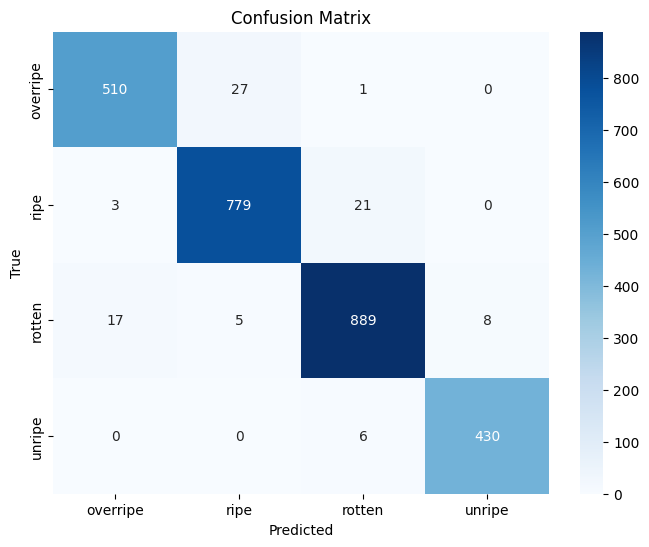

✓ Evaluation complete


In [ ]:
ypred = rf.predict(Xtest)
class_names = [str(label) for label in le.classes_]
print(classification_report(ytest, ypred, target_names=class_names))

cm = confusion_matrix(ytest, ypred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()
print("✓ Evaluation complete")


In [ ]:
joblib.dump(rf, "rf_ripeness_model.joblib")
joblib.dump(le, "label_encoder.joblib")
print("✓ Model and encoder saved")


✓ Model and encoder saved


In [ ]:
def predict_and_display(img_path):
    feats = extract_features(img_path)
    if feats is None:
        print("ERROR: Image not readable or missing!")
        return
    feats = feats.reshape(1, -1)
    probs = rf.predict_proba(feats)[0]
    pred_idx = np.argmax(probs)
    pred_label = le.classes_[pred_idx]
    pred_prob = probs[pred_idx]
    results = {cls: f"{p*100:.2f}%" for cls, p in zip(le.classes_, probs)}
    verdicts = {
        "unripe": ("🟢 UNRIPE", "Not ready to eat. Wait for ripening."),
        "ripe": ("🟡 RIPE", "Ready to eat now!"),
        "overripe": ("🟠 OVERRIPE", "Use soon, best for baking/smoothies."),
        "rotten": ("🔴 ROTTEN", "Do not eat - Discard."),
    }
    verdict, advice = verdicts.get(pred_label, ("Unknown", "No advice"))
    print("\n🍌 Prediction Report")
    print("-"*30)
    print(f"Verdict: {verdict} (Confidence: {pred_prob*100:.2f}%)")
    print(f"Advice: {advice}")
    print("Class probabilities:", results)
    return pred_label, results

# Example usage:
# pred_label, prob_dict = predict_and_display('path/to/image.jpg')


In [ ]:
def gradio_infer(img):
    with tempfile.NamedTemporaryFile(delete=False, suffix='.jpg') as tmp:
        tmp_path = tmp.name
        img.save(tmp_path)
    feats = extract_features(tmp_path)
    if feats is None:
        return "Image error.", {}
    feats = feats.reshape(1, -1)
    probs = rf.predict_proba(feats)[0]
    pred_idx = np.argmax(probs)
    pred_label = str(le.classes_[pred_idx])
    pred_prob = probs[pred_idx]
    verdicts = {
        "unripe": "🟢 UNRIPE - Not ready to eat",
        "ripe": "🟡 RIPE - Ready to eat",
        "overripe": "🟠 OVERRIPE - Use soon",
        "rotten": "🔴 ROTTEN - Discard"
    }
    verdict = verdicts.get(pred_label, "Unknown")
    result = {str(cls): f"{p*100:.2f}%" for cls, p in zip(le.classes_, probs)}
    os.remove(tmp_path)
    return f"{verdict} (Confidence: {pred_prob*100:.2f}%)", result

interface = gr.Interface(
    fn=gradio_infer,
    inputs=gr.Image(type="pil", label="Upload Fruit Image"),
    outputs=[gr.Textbox(label="Verdict"), gr.JSON(label="Class Probabilities")],
    title="🍌 Fruit Ripeness Detection",
    description="Upload an image and get ripeness verdict + probabilities"
)

interface.launch(share=True, show_error=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6adc2ac8a673341650.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
